## Analisi dei dati comunicati dalla Protezione civile relativi all'epidemia COVID-19 in Italia

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
#print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# we are using the inline backend
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

#!conda install -c conda-forge folium=0.5.0 --yes
#import folium # map rendering library

from datetime import datetime

pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

print('Libraries imported.')

Libraries imported.


## Dati 31 marzo

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
body = client_6816ff6b00594052973bfb2ff7e1d9ef.get_object(Bucket='covid19-donotdelete-pr-un4kydphx068hf',Key='Italia-31.3.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_Italia = pd.read_csv(body)

body = client_6816ff6b00594052973bfb2ff7e1d9ef.get_object(Bucket='covid19-donotdelete-pr-un4kydphx068hf',Key='regioni-31.3.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_regioni = pd.read_csv(body)

body = client_6816ff6b00594052973bfb2ff7e1d9ef.get_object(Bucket='covid19-donotdelete-pr-un4kydphx068hf',Key='Province-31.3.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_province = pd.read_csv(body)

In [4]:
def data_change(data):
    cut1=data.find(' ')
    cut2=data.find('T')
    data_str=data[0:max(cut1,cut2)]
    return (datetime.strptime(data_str, '%Y-%m-%d').date())

In [5]:
df_regioni['data']=df_regioni['data'].apply(data_change)
df_province['data']=df_province['data'].apply(data_change)
df_Italia['data']=df_Italia['data'].apply(data_change)

In [6]:
df_regioni.tail(2)

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
775,2020-03-31,ITA,2,Valle d'Aosta,45.737503,7.320149,91,26,117,435,552,34,44,20,56,628,1582,NaN,NaN
776,2020-03-31,ITA,5,Veneto,45.434905,12.338452,1680,356,2036,5814,7850,286,431,828,477,9155,106238,NaN,NaN


In [7]:
df_province.tail(2)

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi,note_it,note_en
4734,2020-03-31,ITA,5,Veneto,24,Vicenza,VI,45.547497,11.545971,1242,NaN,NaN
4735,2020-03-31,ITA,5,Veneto,999,In fase di definizione/aggiornamento,NaN,0.000000,0.000000,279,NaN,NaN


In [8]:
df_Italia.tail(2)

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
35,2020-03-30,ITA,27795,3981,31776,43752,75528,1648,4050,14620,11591,101739,477359,NaN,NaN
36,2020-03-31,ITA,28192,4023,32215,45420,77635,2107,4053,15729,12428,105792,506968,NaN,NaN


In [10]:
def funcpol(x, a, b, c, d, e, f, g, h):
    return a+b*x+c*pow(x, 2)+d*pow(x, 3)+e*pow(x, 4)+f*pow(x, 5)+g*pow(x, 6)+h*pow(x, 7)

def funcexp(x, a, b, c):
    return a * np.exp(b * x) + c

def funcsigmoid(x, alfa, beta, gamma):
    return (beta/(1+np.exp(-gamma*(x-alfa))))

In [11]:
def trend(regione, analisi, func, xdata, len_stima):
    df=df_regioni[df_regioni['denominazione_regione']==regione].reset_index()[[analisi]]
    ydata=np.transpose(df[analisi][:len_stima].array)
    popt, pcov = curve_fit(func, xdata[:len_stima], ydata)
    yhat=func(xdata, *popt).astype(int)
    df['stima']=yhat
    return(df)

In [12]:
def trenditalia(len_stima, xdata, func, analisi):
    df=df_Italia[[analisi]]
    ydata=np.transpose(df_Italia[analisi][:len_stima].array)
    popt, pcov = curve_fit(func, xdata[:len_stima], ydata)
    yhat=func(xdata, *popt).astype(int)
    df['stima']=yhat
    return(df)

In [13]:
def graf(df, regione, analisi, xdata):
    ax1 = df.plot(kind='line', figsize=(8, 4))
    ax1.set_xticks(np.arange(0, len(xdata), 1))
    ax1.set_title('Trend regione {} stima calcolata primi {} giorni'.format(regione, len_stima))
    ax1.set_ylabel(analisi)
    ax1.set_xlabel('giorni dal 24 febbraio')

In [14]:
N_days, N_regions = df_Italia.shape
xdata=np.linspace(0, N_days-1, N_days)

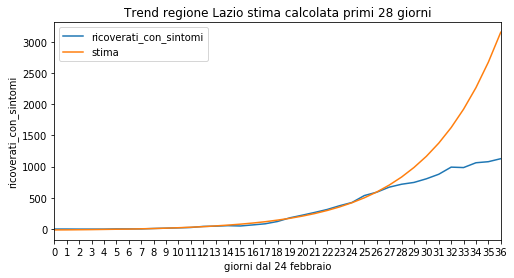

In [15]:
len_stima=28
regione='Lazio'
analisi='ricoverati_con_sintomi'
df=trend(regione, analisi, funcexp, xdata, len_stima)

graf(df, regione, analisi, xdata)

In [16]:
len_stima=28
analisi='ricoverati_con_sintomi'
df=trenditalia(len_stima, xdata, funcexp, analisi)

Text(0.5, 0, 'giorni dal 24 febbraio')

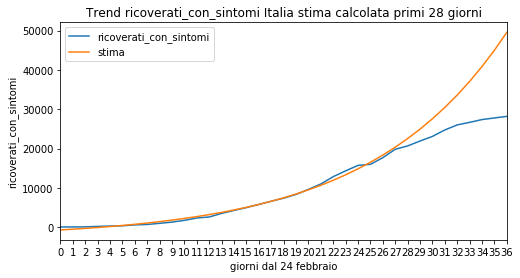

In [17]:
ax1 = df.plot(kind='line', figsize=(8, 4))
ax1.set_xticks(np.arange(0, len(xdata), 1))
ax1.set_title('Trend {} Italia stima calcolata primi {} giorni'.format(analisi, len_stima))
ax1.set_ylabel(analisi)
ax1.set_xlabel('giorni dal 24 febbraio')

In [18]:
N=12
data=df_regioni['data'].iloc[691]
top_N=df_regioni[df_regioni['data']==data].sort_values('ricoverati_con_sintomi', ascending=False).head(N)['denominazione_regione']

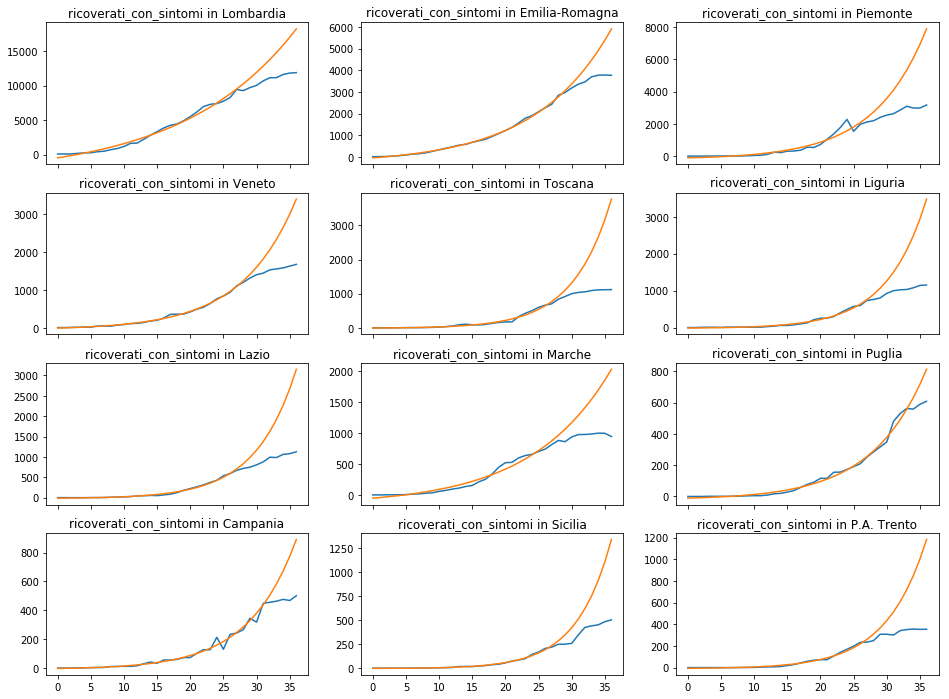

In [19]:
cols=min(len(top_N), 3)
rows=len(top_N)//3+1

if len(top_N)/3>len(top_N)//3:
    rows=len(top_N)//3+1
else:
    rows=len(top_N)//3

fig, axes = plt.subplots(rows, cols, figsize=(16, 12), sharex='col')

indice=0
for row in range(rows):
    for col in range (cols):
        if indice<len(top_N):
            regione=top_N.iloc[indice]
            df=trend(regione, analisi, funcexp, xdata, len_stima)
            #popt, yhat, df=trend(regioni[indice], len_stima, N_days, funcexp)        
            axes[row,col].plot(xdata, df)
            axes[row,col].set_title('{} in {}'.format(analisi, regione))
            indice=indice+1

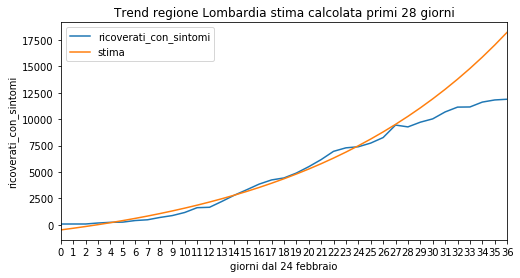

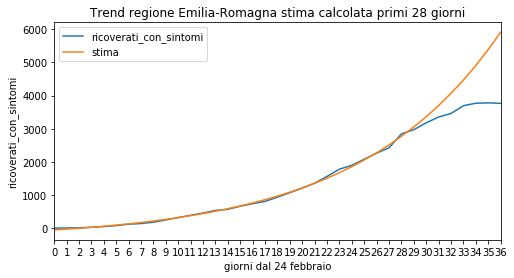

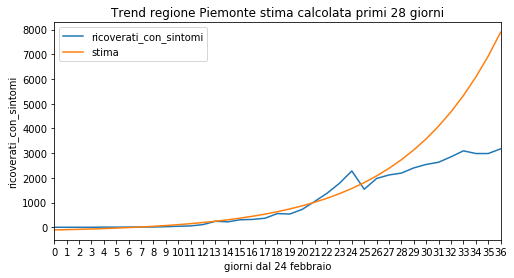

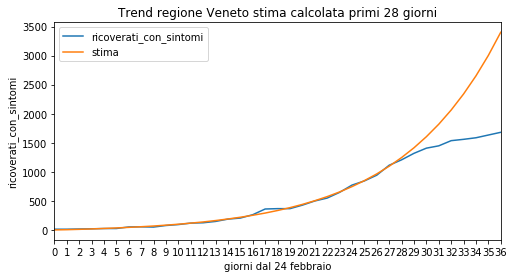

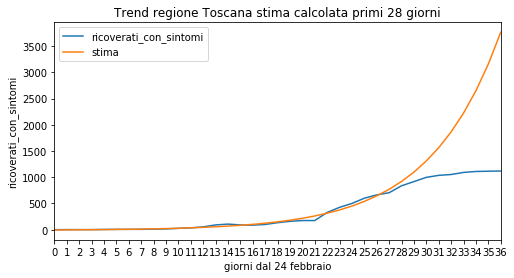

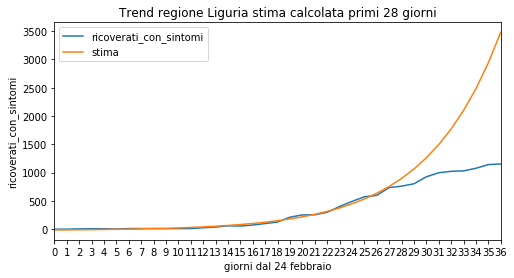

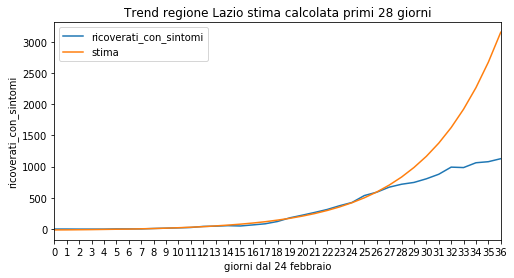

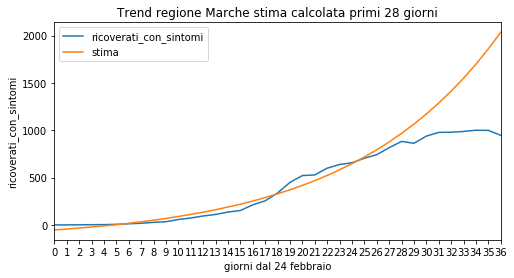

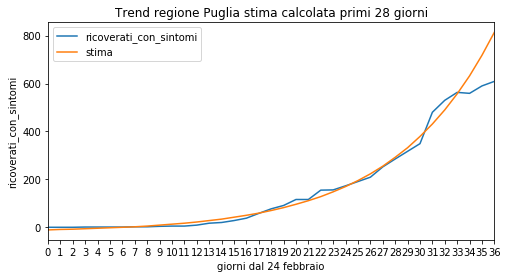

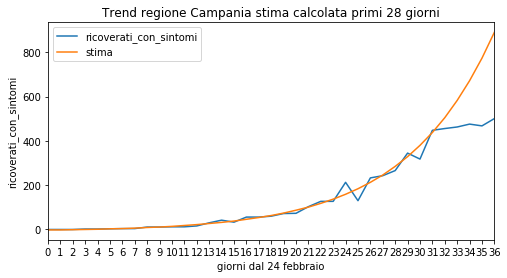

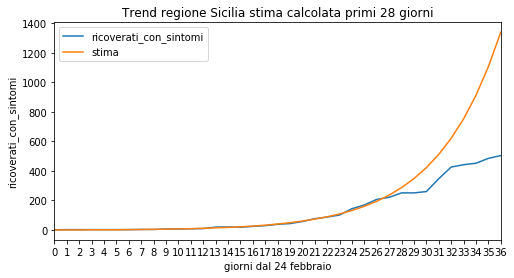

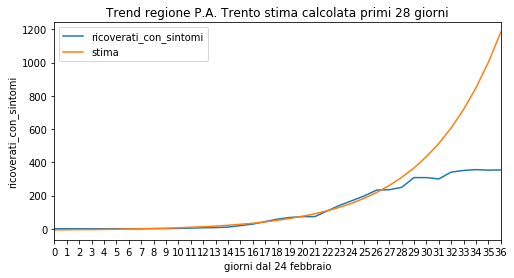

In [20]:
for regione in top_N:
    analisi='ricoverati_con_sintomi'
    df=trend(regione, analisi, funcexp, xdata, len_stima)

    graf(df, regione, analisi, xdata)

Text(0.5, 1.0, 'Frazione dei nuovi positivi sul numero di tamponi effettuati in Lazio')

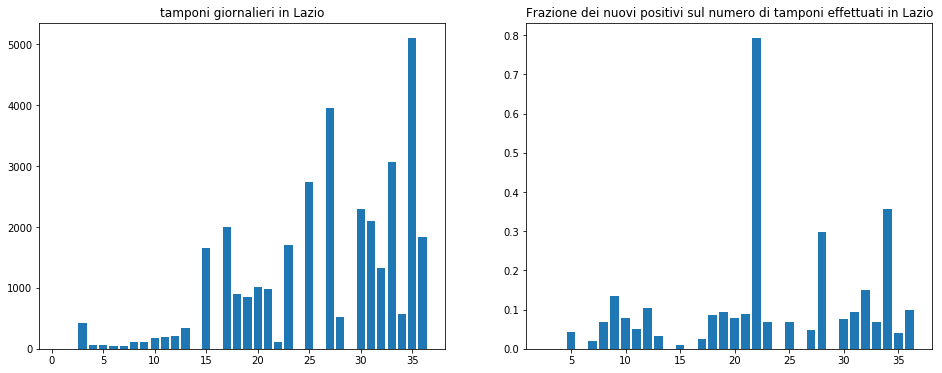

In [27]:
regione='Lazio'
analisi='tamponi'
df['tamponi']=df_regioni[df_regioni['denominazione_regione']==regione].reset_index()[[analisi]].diff()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
#df['diff']=df_regioni[df_regioni['denominazione_regione']==regione].reset_index()[[analisi]].diff()
df['nuovi_positivi']=df_regioni[df_regioni['denominazione_regione']==regione].reset_index()[['nuovi_positivi']]
df['fraz']=df['nuovi_positivi']/df['tamponi']
axes[0].bar(xdata, df['tamponi'])
axes[0].set_title('{} giornalieri in {}'.format(analisi, regione))
axes[1].bar(xdata, df['fraz'])
axes[1].set_title('Frazione dei nuovi positivi sul numero di {} effettuati in {}'.format(analisi, regione))
#axes[row,col].set_title('{} in {}'.format(analisi, regione))
#ax1 = df['fraz'].plot(kind='bar', figsize=(10, 5))
#ax2 = df['tamponi'].plot(kind='bar', figsize=(10, 5))
#ax1.set_xticks(np.arange(0, len(xdata), 1))
#ax1.set_title('Numero giornaliero di {} e {} per la regione {}'.format(analisi, 'nuovi positivi', regione))
#ax1.set_ylabel('{}'.format(analisi))
#ax1.set_xlabel('giorni dal 24 febbraio')
#axes

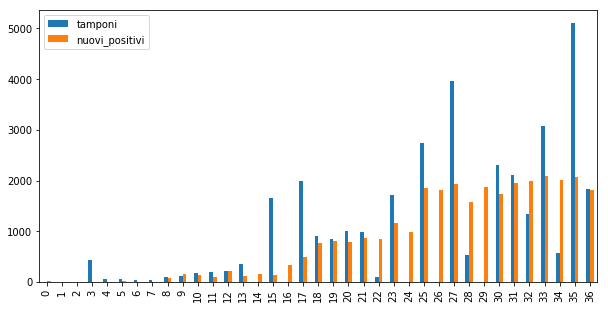

In [28]:
regione='Lazio'
analisi='tamponi'
df['tamponi']=df_regioni[df_regioni['denominazione_regione']==regione].reset_index()[[analisi]].diff()

#fig, axes = plt.subplots(1, 2, figsize=(16, 6))
#df['diff']=df_regioni[df_regioni['denominazione_regione']==regione].reset_index()[[analisi]].diff()
df['nuovi_positivi']=df_regioni[df_regioni['denominazione_regione']==regione].reset_index()[['nuovi_positivi']]*10
#df['fraz']=df['nuovi_positivi']/df['tamponi']
#axes[0].bar(xdata, df['tamponi'])
#axes[0].set_title('{} giornalieri in {}'.format(analisi, regione))
#axes[1].bar(xdata, df['fraz'])
#axes[1].set_title('Frazione dei nuovi positivi sul numero di {} effettuati in {}'.format(analisi, regione))
#axes[row,col].set_title('{} in {}'.format(analisi, regione))
ax = df[['tamponi', 'nuovi_positivi']].plot(kind='bar', figsize=(10, 5))
#ax2 = df['tamponi'].plot(kind='bar', figsize=(10, 5))
#ax1.set_xticks(np.arange(0, len(xdata), 1))
#ax1.set_title('Numero giornaliero di {} e {} per la regione {}'.format(analisi, 'nuovi positivi', regione))
#ax1.set_ylabel('{}'.format(analisi))
#ax1.set_xlabel('giorni dal 24 febbraio')
#axes

In [22]:
top=6
N_days, N_regions = df_casi_regioni.shape
top_regions=df_casi_regioni.iloc[N_days-1].sort_values(ascending=False).head(top).index
df_top_regions=df_casi_regioni[top_regions]
#ax = df_top5.plot(kind='area', alpha=0.35, figsize=(20, 10))
ax = df_top_regions.plot(kind='line', 
                          figsize=(10, 5)) 
ax.set_title('Trend {} regioni'.format(top))
ax.set_ylabel('Numero di casi positivi')
ax.set_xlabel('Giorni dal 24 febbraio')
x_ticks=ax.set_xticks(np.arange(0, N_days, 1))

NameError: name 'df_casi_regioni' is not defined

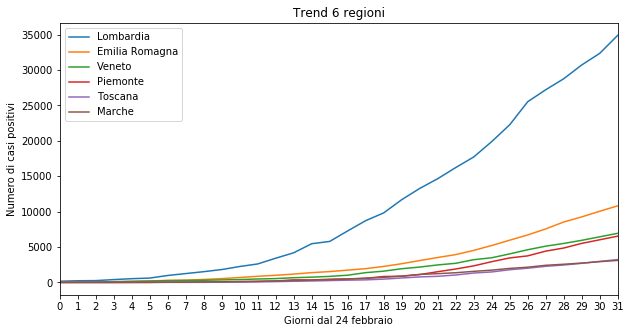

In [22]:
#ax = df_top5.plot(kind='area', alpha=0.35, figsize=(20, 10))
ax = df_top_regions.plot(kind='line', 
                          figsize=(10, 5)) 
ax.set_title('Trend {} regioni'.format(top))
ax.set_ylabel('Numero di casi positivi')
ax.set_xlabel('Giorni dal 24 febbraio')
x_ticks=ax.set_xticks(np.arange(0, N_days, 1))

In [22]:
# Load library
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures

# Load data with one feature
boston = load_boston()
features = boston.data[:,0:1]
target = boston.target

# Create polynomial features x^2 and x^3
polynomial = PolynomialFeatures(degree=3, include_bias=False)
features_polynomial = polynomial.fit_transform(features)

# Create linear regression
regression = LinearRegression()

# Fit the linear regression
model = regression.fit(features_polynomial, target)

In [23]:
regression

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [24]:
target

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
       15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
       13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
       21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
       35.4, 24.7, 31.6, 23.3, 19.6, 18.7, 16. , 22.2, 25. , 33. , 23.5,
       19.4, 22. , 17.4, 20.9, 24.2, 21.7, 22.8, 23.4, 24.1, 21.4, 20. ,
       20.8, 21.2, 20.3, 28. , 23.9, 24.8, 22.9, 23.9, 26.6, 22.5, 22.2,
       23.6, 28.7, 22.6, 22. , 22.9, 25. , 20.6, 28.4, 21.4, 38.7, 43.8,
       33.2, 27.5, 26.5, 18.6, 19.3, 20.1, 19.5, 19.5, 20.4, 19.8, 19.4,
       21.7, 22.8, 18.8, 18.7, 18.5, 18.3, 21.2, 19.2, 20.4, 19.3, 22. ,
       20.3, 20.5, 17.3, 18.8, 21.4, 15.7, 16.2, 18. , 14.3, 19.2, 19.6,
       23. , 18.4, 15.6, 18.1, 17.4, 17.1, 13.3, 17.8, 14. , 14.4, 13.4,
       15.6, 11.8, 13.8, 15.6, 14.6, 17.8, 15.4, 21

Automatically created module for IPython interactive environment


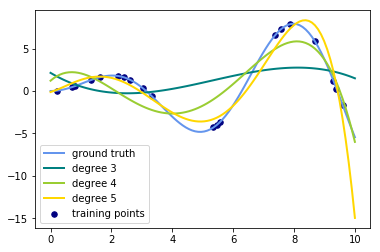

In [31]:
print(__doc__)

# Author: Mathieu Blondel
#         Jake Vanderplas
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


def f(x):
    """ function to approximate by polynomial interpolation"""
    return x * np.sin(x)


# generate points used to plot
x_plot = np.linspace(0, 10, 100)

# generate points and keep a subset of them
x = np.linspace(0, 10, 100)
rng = np.random.RandomState(0)
rng.shuffle(x)
x = np.sort(x[:20])
y = f(x)

# create matrix versions of these arrays
X = x[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

colors = ['teal', 'yellowgreen', 'gold']
lw = 2
plt.plot(x_plot, f(x_plot), color='cornflowerblue', linewidth=lw,
         label="ground truth")
plt.scatter(x, y, color='navy', s=30, marker='o', label="training points")

for count, degree in enumerate([3, 4, 5]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(X, y)
    y_plot = model.predict(X_plot)
    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw,
             label="degree %d" % degree)

plt.legend(loc='lower left')

plt.show()

In [26]:
x_plot

NameError: name 'x_plot' is not defined

In [5]:
x

array([0.2020202 , 0.70707071, 0.80808081, 1.31313131, 1.61616162,
       2.22222222, 2.42424242, 2.62626263, 3.03030303, 3.33333333,
       5.35353535, 5.45454545, 5.55555556, 7.37373737, 7.57575758,
       7.87878788, 8.68686869, 9.29292929, 9.39393939, 9.5959596 ])

In [6]:
y

array([ 0.04053512,  0.45931986,  0.58421217,  1.26978173,  1.61449886,
        1.76715568,  1.59367333,  1.29428011,  0.33654557, -0.63522654,
       -4.2903801 , -4.02006959, -3.69500842,  6.5396357 ,  7.28442965,
        7.8763639 ,  5.84402579,  1.22171343,  0.28964971, -1.63464132])

In [7]:
x=np.linspace(0,23,24)

In [8]:
lazioTC

NameError: name 'lazioTC' is not defined

In [20]:
y=lazioTI['terapia_intensiva']

In [21]:
y

0      1
1      1
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      3
10     7
11     8
12     8
13     8
14     8
15    15
16    18
17    20
18    24
19    25
20    31
21    31
22    44
23    44
Name: terapia_intensiva, dtype: int64

In [22]:
X = x[:, np.newaxis]

In [23]:
X

array([[ 0.],
       [ 1.],
       [ 2.],
       [ 3.],
       [ 4.],
       [ 5.],
       [ 6.],
       [ 7.],
       [ 8.],
       [ 9.],
       [10.],
       [11.],
       [12.],
       [13.],
       [14.],
       [15.],
       [16.],
       [17.],
       [18.],
       [19.],
       [20.],
       [21.],
       [22.],
       [23.]])

In [25]:
plt.plot(x, y, color='cornflowerblue', linewidth=lw,
         label="ground truth")
plt.plot(x, y_plot, color='cornflowerblue', linewidth=lw, 
         label="ground truth")
plt.show()

NameError: name 'x' is not defined

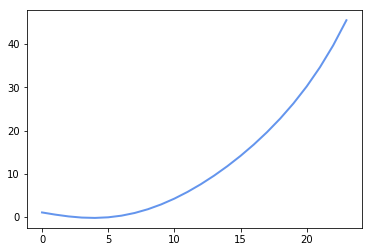

In [54]:
plt.plot(x, y_plot, color='cornflowerblue', linewidth=lw, 
         label="ground truth")

In [27]:
x

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.])

In [30]:
y.shape

(24,)

In [45]:
ydata

array([  101,   114,   128,   248,   345,   401,   639,   742,  1034,
        1346,  1790,  2394,  2651,  3557,  4316,  5038,  5838,  6650,
        7426,  8372,  9663, 11025, 12894, 14363, 15757, 16020, 17708,
       19846, 20692, 21937, 23112, 24753, 26029, 26676, 27386, 27795])

In [46]:
model = make_pipeline(PolynomialFeatures(degree), Ridge())

In [48]:
model.fit(X[:36].reshape(-1,1), ydata.reshape(-1,1))

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=5, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [52]:
#model.fit(X, y)
X=np.linspace(0,70,71)
y_plot = model.predict(X[:50].reshape(-1,1))

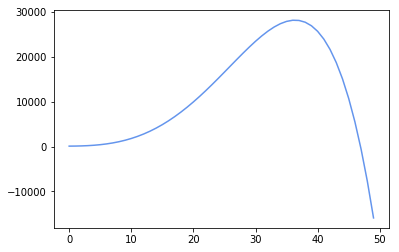

In [53]:
plt.plot(X[:50], y_plot, color='cornflowerblue')

In [40]:
x_plot

array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
        2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
        3.03030303,  3.13131313,  3.23232323,  3.33333333,  3.43434343,
        3.53535354,  3.63636364,  3.73737374,  3.83838384,  3.93939394,
        4.04040404,  4.14141414,  4.24242424,  4.34343434,  4.44444444,
        4.54545455,  4.64646465,  4.74747475,  4.84848485,  4.94949495,
        5.05050505,  5.15151515,  5.25252525,  5.35353535,  5.45454545,
        5.55555556,  5.65656566,  5.75757576,  5.85858586,  5.95959596,
        6.06060606,  6.16161616,  6.26262626,  6.36363636,  6.46464646,
        6.56565657,  6.66666667,  6.76767677,  6.86868687,  6.96

In [45]:
X

array([[ 0.],
       [ 1.],
       [ 2.],
       [ 3.],
       [ 4.],
       [ 5.],
       [ 6.],
       [ 7.],
       [ 8.],
       [ 9.],
       [10.],
       [11.],
       [12.],
       [13.],
       [14.],
       [15.],
       [16.],
       [17.],
       [18.],
       [19.],
       [20.],
       [21.],
       [22.],
       [23.]])

In [60]:
top=70
mu, sigma = 0, 0.3
s = np.random.normal(mu, sigma, 100)

In [61]:
def funcsigmoid(x, alfa, beta, gamma):
    return (beta/(1+np.exp(-gamma*(x-alfa))))

In [62]:
X=np.linspace(0,99,100)

In [63]:
ydata=funcsigmoid(X[:top], 50, 10, 0.1)+s[:top]

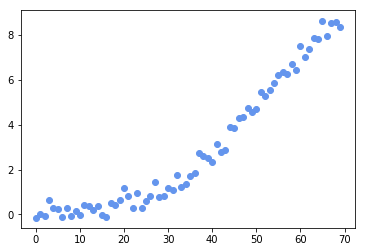

In [64]:
plt.scatter(X[:top], ydata[:top], color='cornflowerblue')

In [65]:
popt, pcov = curve_fit(funcsigmoid, X[:top], ydata[0:top])
yhat=funcsigmoid(X, *popt)

In [66]:
popt

array([50.19334253,  9.92152841,  0.09747907])

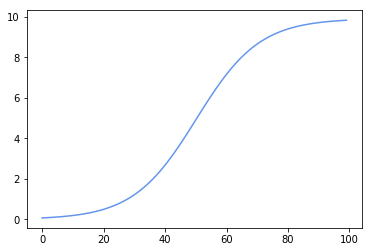

In [67]:
plt.plot(X, yhat, color='cornflowerblue')

In [73]:
a = np.empty((30))
a[:]=np.NaN
ydatanan=np.append(ydata,a)
d={'yhat': yhat, 'ydata': ydatanan}

In [74]:
df = pd.DataFrame(data=d)

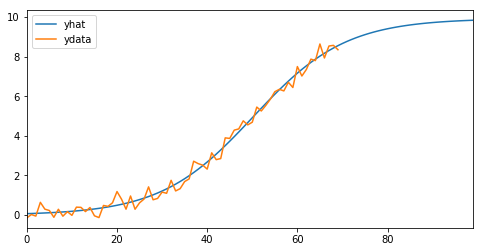

In [75]:
ax1 = df.plot(kind='line', figsize=(8, 4))

In [29]:
ydata=np.transpose(df_regioni[df_regioni['denominazione_regione']=='Lazio']['ricoverati_con_sintomi'].array)

In [72]:
ydata=np.transpose(df_Italia['deceduti'].array)

In [73]:
Ny=ydata.shape[0]

In [74]:
X=np.linspace(0,Ny-1,Ny)

In [75]:
len_sim=50
popt, pcov = curve_fit(funcsigmoid, X, ydata, p0=[1, 0, 1])
yhat=funcsigmoid(np.linspace(0,len_sim-1,len_sim), *popt)

In [76]:
a = np.empty((len_sim-Ny))
a[:]=np.NaN
ydatanan=np.append(ydata,a)
d={'simulazione': yhat, 'dati reali': ydatanan}

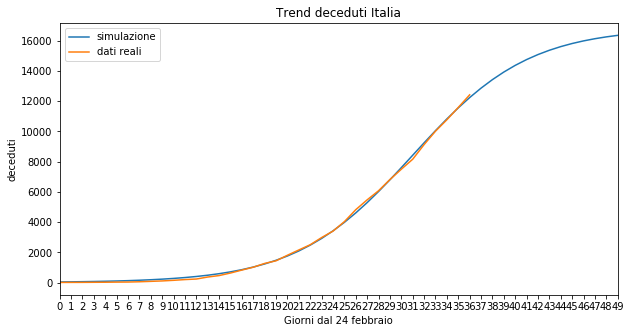

In [77]:
df = pd.DataFrame(data=d)
ax1 = df.plot(kind='line', figsize=(10, 5))
#ax1 = df[['dati reali']].plot(kind='scatter', figsize=(14, 5))
ax1.set_title('Trend {} Italia'.format('deceduti'))
ax1.set_ylabel('deceduti')
ax1.set_xlabel('Giorni dal 24 febbraio')
x_ticks=ax1.set_xticks(np.arange(0, len_sim, 1))

In [69]:
regioni=['Lombardia', 'Veneto', 'Emilia-Romagna', 'Lazio']

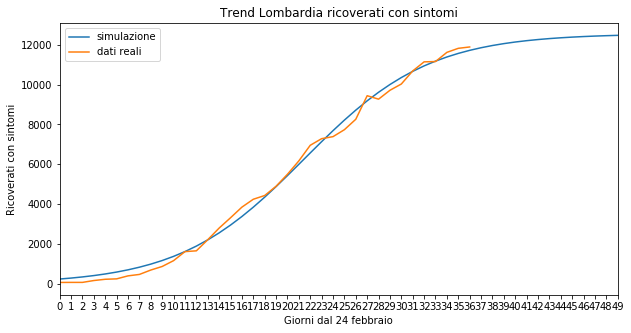

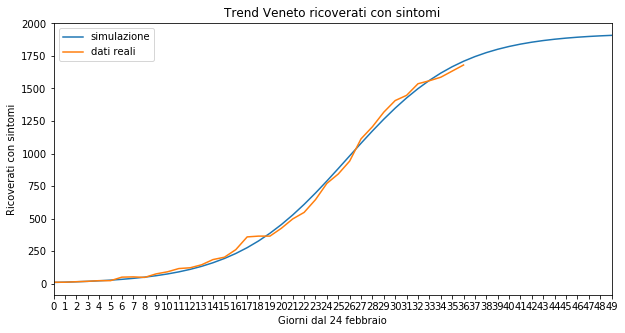

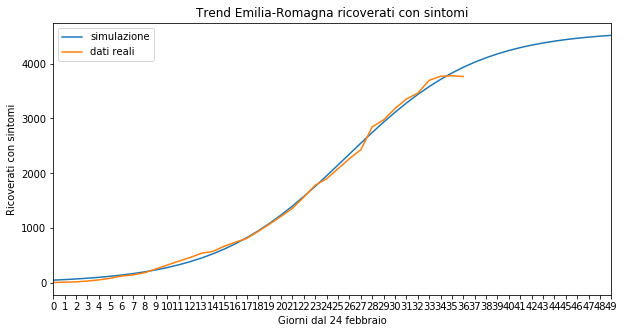

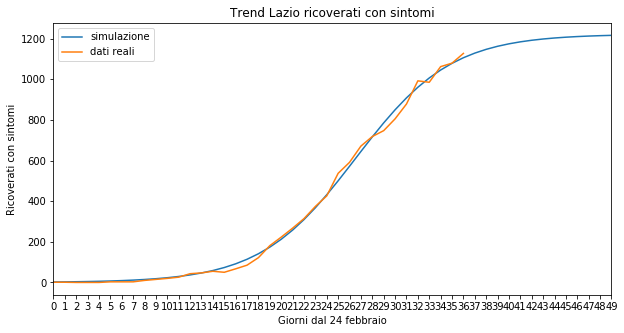

In [70]:
for regione in regioni:
    ydata=np.transpose(df_regioni[df_regioni['denominazione_regione']==regione]['ricoverati_con_sintomi'].array)
    Ny=ydata.shape[0]
    X=np.linspace(0,Ny-1,Ny)
    len_sim=50
    popt, pcov = curve_fit(funcsigmoid, X, ydata, p0=[1, 0, 1])
    yhat=funcsigmoid(np.linspace(0,len_sim-1,len_sim), *popt)
    a = np.empty((len_sim-Ny))
    a[:]=np.NaN
    ydatanan=np.append(ydata,a)
    d={'simulazione': yhat, 'dati reali': ydatanan}
    df = pd.DataFrame(data=d)
    ax1 = df.plot(kind='line', figsize=(10, 5))
    #ax1 = df[['dati reali']].plot(kind='scatter', figsize=(14, 5))
    ax1.set_title('Trend {} {}'.format(regione, 'ricoverati con sintomi'))
    ax1.set_ylabel('Ricoverati con sintomi')
    ax1.set_xlabel('Giorni dal 24 febbraio')
    x_ticks=ax1.set_xticks(np.arange(0, len_sim, 1))

In [71]:
df_Italia

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
0,2020-02-24,ITA,101,26,127,94,221,0,221,1,7,229,4324,NaN,NaN
1,2020-02-25,ITA,114,35,150,162,311,90,93,1,10,322,8623,NaN,NaN
2,2020-02-26,ITA,128,36,164,221,385,74,78,3,12,400,9587,NaN,NaN
3,2020-02-27,ITA,248,56,304,284,588,203,250,45,17,650,12014,NaN,NaN
4,2020-02-28,ITA,345,64,409,412,821,233,238,46,21,888,15695,NaN,NaN
5,2020-02-29,ITA,401,105,506,543,1049,228,240,50,29,1128,18661,NaN,NaN
6,2020-03-01,ITA,639,140,779,798,1577,528,566,83,34,1694,21127,NaN,NaN
7,2020-03-02,ITA,742,166,908,927,1835,258,342,149,52,2036,23345,NaN,NaN
8,2020-03-03,ITA,1034,229,1263,1000,2263,428,466,160,79,2502,25856,NaN,NaN
9,2020-03-04,ITA,1346,295,1641,1065,2706,443,587,276,107,3089,29837,NaN,NaN
